In [2]:
import numpy as np
import matplotlib.pyplot as plt

# PCA

PCA stands for "principal components analysis".

The "principal components" in PCA are the axes of covariation. Intuition: if you look at a pairplot, in what direction (if any) do you see the variables pointing?

The idea behind PCA is:
* find the components (the intrinsic axes of variation)
* order them from largest to smallest
* drop the smallest ones

This gives a data set with fewer variables, but that still has most of the information of the full dataset. Note that this type of projection does *not drop data variables*, instead it drops variation between data variables.



We can do this using matrix math!
* Rotate so the principal coordinates become coordinate axes (translation then rotation), then 
* drop the lesser ones, then 
* reverse the rotation and translation: $$A_{reconstruct} = (P@A_c^T)^T + \mu = A_c @ P^T + \mu$$
    
The rotation matrix is the *eigenvectors* of the covariance matrix. The eigenvectors tell us the direction of the principal components. The eigenvalues tell us the amount of variation in each principal coordinate direction.

(For more on eigenvalues and eigenvectors, see Linear Algebra or https://www.mathsisfun.com/algebra/eigenvalue.html)


The eigenvectors are *orthonormal*. What does that mean?

So the steps to calculate PCA are:

0. (If appropriate) normalize the variables to be in the range 0-1
1. Center the data
2. Compute the covariance matrix
3. Compute the eigenvectors and eigenvalues; the eigenvectors tell us the direction of variance, and the eigenvalues tell us the amount of variance
4. Get an ordering over the eigenvalues
5. Sort the eigenvalues and eigenvectors accordingly
6. Compute the proportional variance (how much bigger?) accounted for by each principal component
7. Compute the cumulative sum of the proportional variance (tells us how many eigenvectors we need to explain a desired amount of variance)
8. Examine the principal components. Select v' of them.
9. Project the data into PCA space
10. Reconstruct the data

Let's do it on a small dataset so we can see what's going on!

[[1. 4.]
 [2. 3.]
 [3. 2.]
 [4. 1.]]


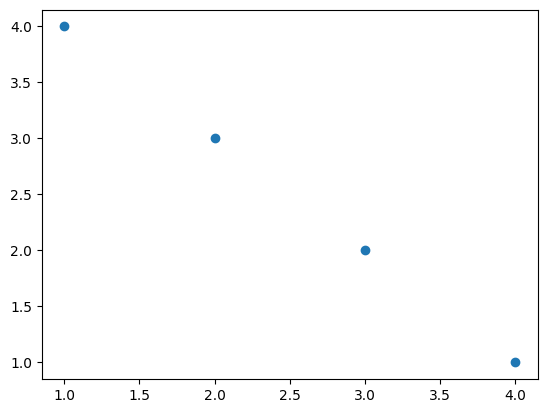

In [3]:
data = np.array([[1, 4],[2, 3], [3, 2], [4, 1.0]])
print(data)
columns = ['x,', 'y']

plt.scatter(x = data[:, 0], y=data[:, 1])
plt.show()

First, center the data.

(4, 2)


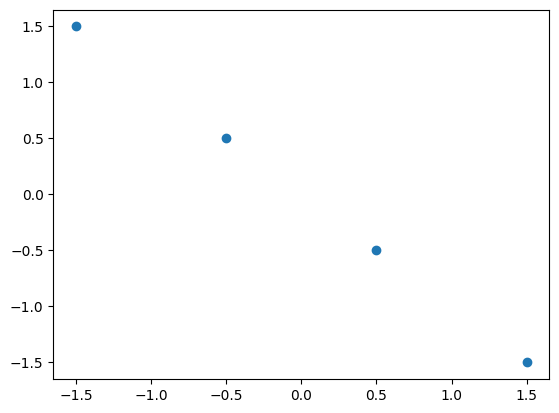

In [4]:
centered_data = data - np.mean(data, axis=0)
print(centered_data.shape)
plt.scatter(x = centered_data[:, 0], y=centered_data[:, 1])
plt.show()

Second, compute the covariance matrix.

In [5]:
covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)
print(covariance_matrix.shape)
print(covariance_matrix)

(2, 2)
[[ 1.66666667 -1.66666667]
 [-1.66666667  1.66666667]]


Third, get the eigenvalues and eigenvectors.

In [6]:
(evals, evectors) = np.linalg.eig(covariance_matrix)
print(evals.shape, evectors.shape)
print(evals, evectors)

(2,) (2, 2)
[ 3.33333333e+00 -4.44089210e-16] [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


*Let's pause and look up this eig function. Do the eigenvectors run along the rows or columns of the returned matrix?*

Fourth, get an ordering over the eigenvalues.

In [9]:
# Get an ordering over the eigenvalues

evals_order = np.argsort(evals)[::-1]
print(evals_order)

[0 1]


Fifth, sort the eigenvalues and eigenvectors according to that order.

In [10]:
evals_sorted = evals[evals_order]
for e in evals_sorted:
    print(e)

evectors_sorted = evectors[:, evals_order]
print(evectors_sorted.shape)

3.333333333333333
-4.440892098500626e-16
(2, 2)


Sixth, calculate the proportional variances.

In [11]:
evals_sum = np.sum(evals_sorted)
ps = [eval / evals_sum for eval in evals_sorted]
print(ps)

[1.0000000000000002, -1.332267629550188e-16]


Seventh, calculate the cumulative sum of the proportional variances.

In [12]:
c = 0
for i in range(len(ps)):
    c = c + ps[i]
    print(i, ps[i], c)

0 1.0000000000000002 1.0000000000000002
1 -1.332267629550188e-16 1.0


Eighth, examine the principal components. Select the top $n$ of them.

In [13]:
print(evectors_sorted)

v = np.array([evectors_sorted[:, 0]]).T
print(v)

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
[[ 0.70710678]
 [-0.70710678]]


Ninth, project the data into PCA space.

In [14]:
projected_data = centered_data@v
print(projected_data)

[[-2.12132034]
 [-0.70710678]
 [ 0.70710678]
 [ 2.12132034]]


Tenth, reconstruct the data with only the chosen principal components.

[[1. 4.]
 [2. 3.]
 [3. 2.]
 [4. 1.]]


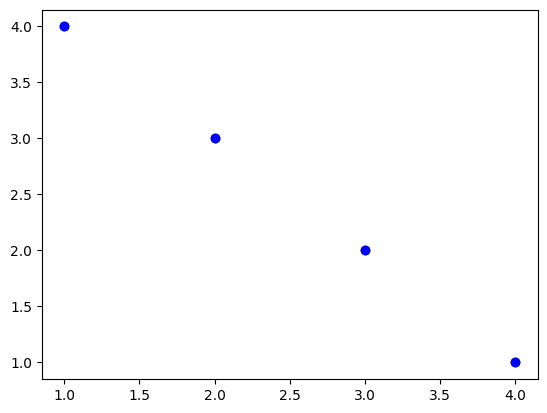

In [15]:
reconstructed_data = projected_data@v.T + np.mean(data, axis=0)
print(reconstructed_data)
plt.scatter(x = reconstructed_data[:, 0], y=reconstructed_data[:, 1], color="black")
plt.scatter(x = data[:, 0], y=data[:, 1], color="blue")
plt.show()

If we do all this, then:
* what does the data look like in "PCA space"?
* what does it look like projected back?
* how does a regression fit on the PC transformed data compare with one fit on the original data?
* What if all the points were on a line?

# Extra! Bonus! (May not get to in class) PCA on our data

First, load our data.

In [ ]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()

# fix up some of these ones we know are ordered
colValues[columns.index('condition')] = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
colValues[columns.index('title_status')] = ['clean', 'lien', 'rebuilt', 'salvage', 'parts only', 'missing']

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  
print(data.shape)

Let's z-score it.

In [ ]:
homogenizedData = np.append(data, np.array([np.ones(data.shape[0], dtype=int)]).T, axis=1)

translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    translateTransform[i, -1] = -data[:, i].mean()

scaleTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    scaleTransform[i, i] = 1/data[:, i].std()

totalTransform = scaleTransform@translateTransform

transformedData = (totalTransform @ homogenizedData.T).T

transformedData = transformedData[:, 0:-1]
print(transformedData.shape)

In [ ]:
import pandas as pd
import seaborn

df = pd.DataFrame(transformedData, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

Split it into train and test. Split off the dependent variable from each.

In [ ]:
transformedData = transformedData[data[:, 1].argsort()]

(train, test) = np.split(transformedData, [int(len(transformedData) / 10 * 8)])
trainx = train[:, 1:]
trainy = train[:, 0]
testx = test[:, 1:]
testy = test[:, 0]
print(trainx.shape, testx.shape)


Second, fit PCA using training data.

In [ ]:
# Now let's do it on our big dataset!
import scipy as sp

# center
centered_train = trainx - np.mean(trainx, axis=0)
print("centered train: ", centered_train.shape)

# covariance
covariance_matrix = (centered_train.T @ centered_train) / (centered_train.shape[0] - 1)
print("covariance matrix: ", covariance_matrix.shape)

# svd
(evals, evectors) = np.linalg.eig(covariance_matrix)
print("eigenvalues, eigenvectors: ", evals.shape, evectors.shape)

# sort
evals_order = np.argsort(evals)[::-1]
evals_sorted = evals[evals_order]
evectors_sorted = evectors[:, evals_order]
print("sorted eigenvalues")
for e in evals_sorted:
    print(e)

# proportional variance
evals_sum = np.sum(evals_sorted)
ps = [e / evals_sum for e in evals_sorted]

# cumulative sum of proportional variance
print("cum sum prop var")
c = 0
for i in range(len(ps)):
    c = c + ps[i]
    print(i, ps[i], c)

Figure out how many eigenvectors to keep!

In [ ]:
# v with five
v = evectors_sorted[np.ix_(np.arange(evectors_sorted.shape[0]), [0, 1,2,3,4,5])]
print("v")
print(v.shape)

Project the training data and the test data.

In [ ]:
# project into PCA space
projected_train = centered_train@v
print("projected train: ", projected_train.shape)

# center
centered_test = testx - np.mean(testx, axis=0)
print("centered test: ", centered_test.shape)

# project into PCA space
projected_test = centered_test@v
print("projected test: ", projected_test.shape)


## Linear regression on the original data

This code comes directly from day 16.

In [ ]:
import scipy.linalg as sp_la

# x a matrix of multiple independent variables
# poly -> polys, a matrix of multiple polynomial degrees for each column in x in order
def makePoly(x, polys):
    # make an empty array of size A
    A = np.zeros([x.shape[0], np.sum(polys)+1])
    # left most column of 1s for the intercept
    # notice this is also a third way to get that leading column of ones!
    A[:, 0] = np.squeeze(x[:, 0]**0)
    k = 1
    # for each variable
    for (j, poly) in enumerate(polys):
        # for up to and including! poly
        for i in range(1, poly+1):
            A[:, k] = np.squeeze(x[:, j]**i)
            k += 1
    return A

def fit(data, independent, dependent, polys):
    # This is our independent variable, just one for now
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add the polynomials, and a column of 1s for the intercept
    A = makePoly(x, polys)

    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    # We use _ when we don't want to remember something a function returns
    c, _, _, _ = sp_la.lstsq(A, y)
    return c

def predict(data, independent, polys, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add the polynomials, and a column of 1s for the intercept
    A = makePoly(x, polys)

    return np.dot(A, c)

def msse(y, yhat):
    r = (np.square(y - yhat)).mean()
    return r

def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

Fit a multiple linear regression.

In [ ]:
# we will use all our independent variables
variableset = list(range(trainx.shape[1]))

# all with polynomial 1
polys = [1 for x in range(len(variableset))]
c = fit(trainx, list(variableset), 0, polys)
# calculate MSSE and R^2
print(msse(trainy, predict(trainx, variableset, polys, c)), 
      rsquared(testy, predict(testx, variableset, polys, c)))

## Linear regression on the projected data

In [ ]:
# we will use all our independent variables
variableset = list(range(projected_train.shape[1]))

# all with polynomial 1
polys = [1 for x in range(len(variableset))]
c = fit(projected_train, list(variableset), 0, polys)
# calculate MSSE and R^2
print(msse(trainy, predict(projected_train, variableset, polys, c)), 
      rsquared(testy, predict(projected_test, variableset, polys, c)))

Resources:
* https://plotly.com/python/pca-visualization/
* https://wendynavarrete.com/principal-component-analysis-with-numpy/
* https://dev.to/akaame/implementing-simple-pca-using-numpy-3k0a